<a href="https://colab.research.google.com/github/mtablado/uoc2022_tfm/blob/main/ce-vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://learnopencv.com/variational-autoencoder-in-tensorflow/

https://keras.io/examples/generative/vae/

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adagrad
import numpy as np
import math

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
from google.colab import drive
# Force the mount due to several errors with drive sync
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [5]:
def vae_encoder():
  latent_dim = 2

  inputs = keras.Input(shape=(256, 256, 1), name='input_layer')

  # Block-1
  x = layers.Conv2D(32, kernel_size=3, strides= 2, padding='same', name='conv_1')(inputs)
  x = layers.BatchNormalization(name='bn_1')(x)
  x = layers.LeakyReLU(name='lrelu_1')(x)

  # Block-2
  x = layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(x)
  x = layers.BatchNormalization(name='bn_2')(x)
  x = layers.LeakyReLU(name='lrelu_2')(x)

  # Block-3
  x = layers.Conv2D(64, 3, 2, padding='same', name='conv_3')(x)
  x = layers.BatchNormalization(name='bn_3')(x)
  x = layers.LeakyReLU(name='lrelu_3')(x)

  # Block-4
  x = layers.Conv2D(64, 3, 2, padding='same', name='conv_4')(x)
  x = layers.BatchNormalization(name='bn_4')(x)
  x = layers.LeakyReLU(name='lrelu_4')(x)

  # Block-5
  x = layers.Conv2D(64, 3, 2, padding='same', name='conv_5')(x)
  x = layers.BatchNormalization(name='bn_5')(x)
  x = layers.LeakyReLU(name='lrelu_5')(x)

  # Final Block
  flatten = layers.Flatten()(x)
  mean = layers.Dense(200, name='mean')(flatten)
  log_var = layers.Dense(200, name='log_var')(flatten)
  z = Sampling()([mean, log_var])
  model = tf.keras.Model(inputs, (mean, log_var, z), name="Encoder")
  model.summary()
  return model

encoder = vae_encoder()

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv_1 (Conv2D)                (None, 128, 128, 32  320         ['input_layer[0][0]']            
                                )                                                                 
                                                                                                  
 bn_1 (BatchNormalization)      (None, 128, 128, 32  128         ['conv_1[0][0]']                 
                                )                                                           

In [6]:
def vae_decoder():
  inputs = keras.Input(shape=(200,), name='input_layer')
  x = layers.Dense(4096, name='dense_1')(inputs)
  x = layers.Reshape((8,8,64), name='Reshape')(x)

  # Block-1
  x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same',name='conv_transpose_1')(x)
  x = layers.BatchNormalization(name='bn_1')(x)
  x = layers.LeakyReLU(name='lrelu_1')(x)

  # Block-2
  x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(x)
  x = layers.BatchNormalization(name='bn_2')(x)
  x = layers.LeakyReLU(name='lrelu_2')(x)

  # Block-3
  x = layers.Conv2DTranspose(64, 3, 2, padding='same', name='conv_transpose_3')(x)
  x = layers.BatchNormalization(name='bn_3')(x)
  x = layers.LeakyReLU(name='lrelu_3')(x)

  # Block-4
  x = layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_4')(x)
  x = layers.BatchNormalization(name='bn_4')(x)
  x = layers.LeakyReLU(name='lrelu_4')(x)

  # Block-5
  outputs = layers.Conv2DTranspose(1, 3, 2,padding='same', activation='sigmoid', name='conv_transpose_5')(x)
  model = tf.keras.Model(inputs, outputs, name="Decoder")
  model.summary()
  return model

decoder = vae_decoder()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200)]             0         
                                                                 
 dense_1 (Dense)             (None, 4096)              823296    
                                                                 
 Reshape (Reshape)           (None, 8, 8, 64)          0         
                                                                 
 conv_transpose_1 (Conv2DTra  (None, 16, 16, 64)       36928     
 nspose)                                                         
                                                                 
 bn_1 (BatchNormalization)   (None, 16, 16, 64)        256       
                                                                 
 lrelu_1 (LeakyReLU)         (None, 16, 16, 64)        0         
                                                           

In [7]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            r_loss = tf.reduce_mean(tf.square(data - reconstruction), axis = [1,2,3])
            reconstruction_loss = 1000 * r_loss
            #reconstruction_loss = tf.reduce_mean(
            #    tf.reduce_sum(
            #        keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
            #    )
            #)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        result = {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
        return result 


Images stored with *matplotlib.imsave* are not normalized, so we will rescale the pixels while reading

https://medium.com/analytics-vidhya/understanding-image-augmentation-using-keras-tensorflow-a6341669d9ca

In [8]:
import numpy as np
import cv2
path_to_file="/content/drive/My Drive/tfm/dataset/slices/training/t1/IXI002-Guys-0828-T1_0.png"
img=cv2.imread(path_to_file,0)# read in image as grayscale
max_pixel_value=np.max(img) #  find maximum pixel value
min_pixel_value=np.min(img) # find minimum pixel value
print('max pixel value= ', max_pixel_value, '  min pixel value= ', min_pixel_value)

max pixel value=  255   min pixel value=  0


In [9]:
%cd /content/drive/My Drive/tfm/dataset/slices-160-190
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255 # To normalize values
    )
train_generator = train_datagen.flow_from_directory(
        'training',
        target_size=(256, 256),
        batch_size=64, # Number of images processed together
        color_mode='grayscale',
        class_mode=None)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        'test',
        target_size=(256, 256),
        batch_size=64,
        color_mode='grayscale',
        class_mode=None)

/content/drive/.shortcut-targets-by-id/1yKlrvb9Cp3amASiDUettfP3V1KJuzGDe/tfm/dataset/slices-160-190
Found 16268 images belonging to 1 classes.
Found 1162 images belonging to 1 classes.


In [10]:
import timeit
vae = VAE(encoder, decoder)
vae.compile(
    optimizer=keras.optimizers.Adam())

# Entrenar el modelo
t0 = timeit.default_timer()

mfit = vae.fit(train_generator, epochs=60, batch_size=64)
training_time_ann = timeit.default_timer() - t0

Epoch 1/60
255/255 [==============================] - 306s 1s/step - loss: 51.9371 - reconstruction_loss: 27.4224 - kl_loss: 3.0979
Epoch 2/60
255/255 [==============================] - 52s 203ms/step - loss: 19.8820 - reconstruction_loss: 17.1406 - kl_loss: 2.1440
Epoch 3/60
255/255 [==============================] - 52s 204ms/step - loss: 17.7567 - reconstruction_loss: 15.9799 - kl_loss: 1.6251
Epoch 4/60
255/255 [==============================] - 52s 204ms/step - loss: 17.2531 - reconstruction_loss: 15.4066 - kl_loss: 1.7238
Epoch 5/60
255/255 [==============================] - 52s 203ms/step - loss: 16.4362 - reconstruction_loss: 14.5089 - kl_loss: 1.7510
Epoch 6/60
255/255 [==============================] - 52s 203ms/step - loss: 16.1129 - reconstruction_loss: 14.2208 - kl_loss: 1.8098
Epoch 7/60
255/255 [==============================] - 52s 205ms/step - loss: 15.9360 - reconstruction_loss: 14.0752 - kl_loss: 1.8633
Epoch 8/60
255/255 [==============================] - 52s 203ms/

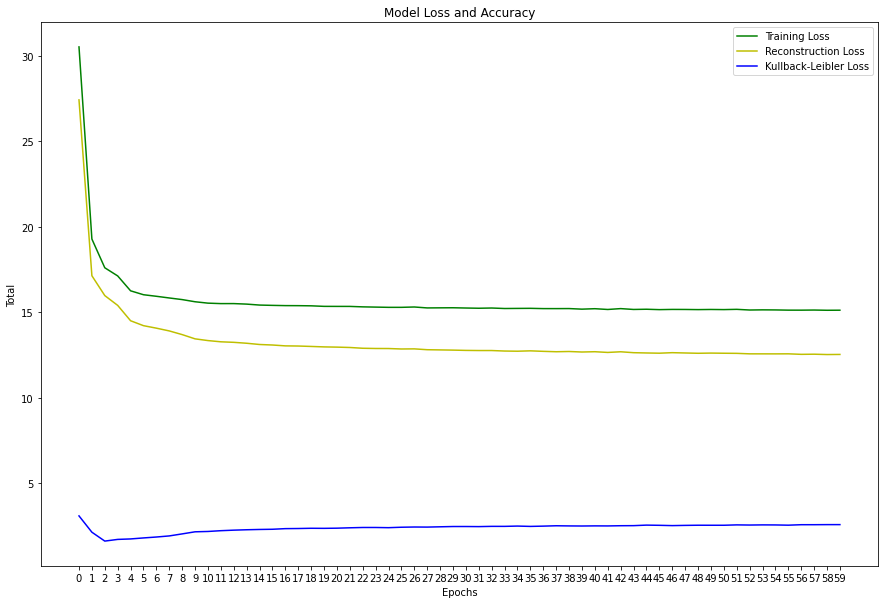

In [15]:
from matplotlib import pyplot as plt
%matplotlib inline

# Plot del training loss y el accuracy
def plot_loss(n_epochs, mfit):
  loss = mfit.history['loss']
  rec_loss = mfit.history['reconstruction_loss']
  kl_loss = mfit.history['kl_loss']
  
  epochs = range(0,n_epochs)
  plt.subplots(figsize=(15,10))
  plt.plot(epochs, loss, 'g', label='Training Loss')
  plt.plot(epochs, rec_loss, 'y', label='Reconstruction Loss')
  plt.plot(epochs, kl_loss, 'b', label='Kullback-Leibler Loss')

  plt.title('Model Loss and Accuracy')
  plt.xticks(epochs)
  plt.xlabel('Epochs')
  plt.ylabel('Total')
  plt.legend()
  plt.show()

plot_loss(60, mfit)

In [12]:
mean, log_var, z = encoder.predict(test_generator)
y_pred = decoder.predict(z)

37/37 [==============================] - 1s 14ms/step


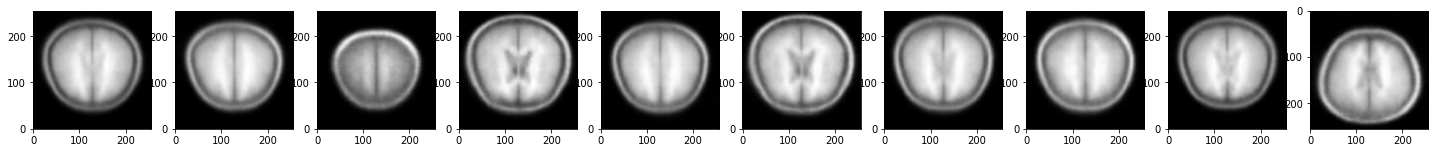

In [13]:
from matplotlib import pyplot as plt
%matplotlib inline

number_of_images = 10 #len(y_pred)
fig, axes = plt.subplots(1, number_of_images, figsize=(25,25))

# Show some images
for i in range(len([0,1,2,3,4,5,6,7,8,9])):
  image = y_pred[i]
  image = image[:,:,0]
  axes[i].imshow(image, cmap="gray", origin="lower")
  # Display the first image in training data
  #img = image[:,:,100]
  plt.imshow(image, cmap='gray')

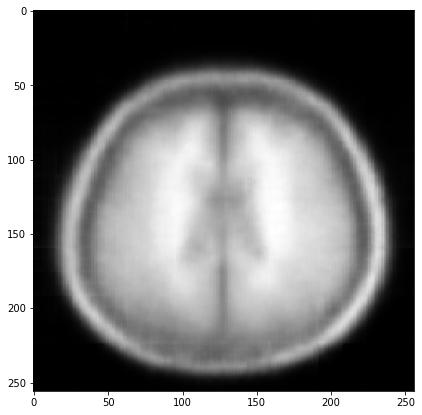

In [14]:
plt.figure(figsize=[15,15])

# Display the first image in training data
plt.subplot(121)
plt.imshow(image, cmap='gray')